In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.decomposition import PCA
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS

os.environ['OPENAI_API_KEY'] = 'key'

In [2]:
with open('data_input/scipdf.pkl', 'rb') as handle:
    pdf_dict = pickle.load(handle)
    
pdf_doi_dict = {}
for pdf_name in pdf_dict.keys():
    pdf_doi_dict[pdf_name.replace(".pdf", "")] = pdf_dict[pdf_name]["doi"]

# Load the FAISS 

In [4]:
# The embedding function to use
embeddings = OpenAIEmbeddings()

# Read the vectorstore object
db = FAISS.load_local("data_faiss/abstracts/", embeddings,
                      allow_dangerous_deserialization=True)

/Users/eporetsky/mambaforge/envs/llm/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [5]:
trait_class = pd.read_csv("data_input/trait_class.tsv", sep="\t")
col_name = "Secondary" # "Traits"
trait_class_dict = trait_class.set_index('PDF')[col_name].to_dict()

# This extracts all the unique trait classes
# trait_classes = []
# [trait_classes.extend(traits.split(",")) for traits in trait_class["Traits"].unique().tolist()]
# trait_classes = list(set(trait_classes))

from random import randint
trait_classes = trait_class[col_name].unique().tolist()
color_dict = {}
n = len(trait_classes)
for i, val in enumerate(trait_classes):
    color_dict[val] = '#%06X' % randint(0, 0xFFFFFF)

# Part 2 - LLM-based trait-category classification

In [ ]:
response_list = []
for rep in range(3):
    for key, val in pdf_dict.items():
        key = key.replace(".pdf", "")
        embeddings = OpenAIEmbeddings()
        db = FAISS.load_local("data_faiss/abstracts/{}".format(key), embeddings,
                              allow_dangerous_deserialization=True)
        retriever = db.as_retriever()

        query = """You are provided with an abstract of a research paper dealing with genetic mapping results. \
                   Your goal is to categorize the research paper based on the types of traits that were measured. \
                   You are to choose from the following categories:
                       - Agronomic \
                       - Abiotic \
                       - Biotic \
                   Select only a single category that best describes the manuscript. \
                   Your response should only include the name of the category and no other information.
                """
#Return your results as a comma-separated list. \
#Only include categories that you are certain about and don't make up answers. \
#You can select more than one category of traits for this manuscript. \        
        #llm = ChatOpenAI(model_name='gpt-3.5-turbo-1106')
        llm = ChatOpenAI(model_name='gpt-4')
        qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)
        abstract_response = qa(query)
        response_list.append([rep+1, key, pdf_doi_dict[key], trait_class_dict[key], abstract_response['result']])
        #print(response_list[-1])
output_df = pd.DataFrame(response_list)
output_df.columns = ["rep", "id", "doi", "label", "pred"]
output_df.to_csv("data_output/abstracts/final_abstract_classes.gpt4.tsv", sep="\t")

<Axes: xlabel='Model', ylabel='% correct'>

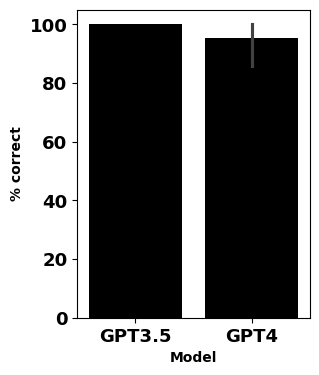

In [8]:
# figure size in inches
plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(3, 4))

tmp1 = pd.read_csv("data_output/abstracts/final_abstract_classes.gpt3.5.tsv", sep="\t")
tmp1["Model"] = "GPT3.5"
tmp2 = pd.read_csv("data_output/abstracts/final_abstract_classes.gpt4.tsv", sep="\t")
tmp2["Model"] = "GPT4"
results = pd.concat([tmp1, tmp2])
#results = pd.read_csv("data_output/abstracts/abstract_classes.gpt4.tsv", sep="\t")
results = results[["rep", "id", "Model","correct"]]
results["correct"] = results["correct"] * 100
results = results.groupby(["id", "Model"]).mean()
results = results.reset_index()
results.columns = ["id", "Model", "rep", "% correct"]
sns.barplot(data=results, x="Model", y= "% correct", color="black")

# Get the embedding vector for all abstracts

In [6]:
def get_faiss_embeddings(faiss_db_name):
    emb_df = pd.DataFrame()
    key_list = []
    for key in pdf_dict.keys():
        # The embedding function to use
        embeddings = OpenAIEmbeddings()
        key = key.replace(".pdf", "")
        db = FAISS.load_local(faiss_db_name, embeddings,
                              allow_dangerous_deserialization=True)
        emb = [db.index.reconstruct_n(idx, 1)[0] for idx in range(db.index.ntotal)]
        key_list.append(key)
    emb_df = pd.concat([emb_df, pd.DataFrame(emb)])
    emb_df.index = key_list
    return(emb_df)

emb_df = get_faiss_embeddings("data_faiss/abstracts")

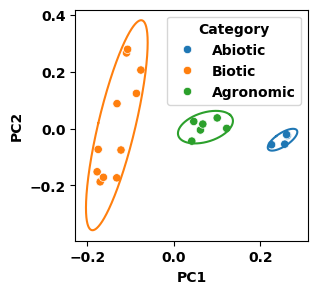

In [7]:
#https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipse-in-a-scatterplot-using-matplotlib

pca = PCA(n_components=2)
pca = pca.fit_transform(np.array(emb_df))

pdf_doi = list(emb_df.index)
pdf_class  = [trait_class_dict[ix] for ix in emb_df.index]
pdf_colors = [color_dict[trait_class_dict[ix]] for ix in emb_df.index]

test = pd.DataFrame([pca[:, 0], pca[:, 1]]).T
test.columns = ["PC1", "PC2"]
test["color"] = pdf_class

plt.rcParams["axes.labelsize"] = 10
# Set font properties globally using rcParams
plt.rcParams.update({'font.weight': 'bold', 'axes.labelweight': 'bold', 'axes.titleweight': 'bold', 'font.size': 10})
fig, ax = plt.subplots(figsize=(3, 3))

sns.scatterplot(data=test, x="PC1", y="PC2", hue="color", ax=ax) # sizes=100,

for group in test["color"].unique():
    tmp = test[test["color"]==group]
    x, y = tmp["PC1"], tmp["PC2"]
    cov = np.cov(x, y)
    val, rot = np.linalg.eig(cov)
    val = np.sqrt(val)
    center = np.mean([x, y], axis=1)[:, None]
    t = np.linspace(0, 2.0 * np.pi, 1000)
    xy = np.stack((np.cos(t), np.sin(t)), axis=-1)
    plt.plot(*(2 * rot @ (val * xy).T + center))
plt.legend(loc='upper right', title="Category", prop={'size': 10})